In [1]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
# The function get_regression_label_from_par reads a .par file and returns 
# the F-region maximum O-mode frequency and the F-region height.
# Both the foF and hF must be values (can not be 'nan'). 

def get_regression_label_from_par(par_file_path):
    try:
        # Open the file at the specified path
        with open(par_file_path, 'r') as file:
            content = file.readline().strip()  # Read the first line and remove leading/trailing whitespace
            items = content.split()  # Split the line into individual items

            # Check if both the first and third items are not 'nan' (not a number)
            # If they are both valid numbers, convert them to floats and return them as a tuple
            if items[1].lower() != 'nan' and items[3].lower() != 'nan':
                return float(items[1]), float(items[3])
            else:
                # If either item is 'nan', return None
                return None
    except Exception as e:
        # Print an error message if an exception occurs while processing the file
        print(f"Error reading {par_file_path}: {e}")
        # Return None if there is an error
        return None


In [3]:
# The load_data function loads and preprocesses image data from a specified directory,
# converting images to grayscale and resizing them, while also extracting corresponding
# scaling parameters from associated .par files for a regression task.

from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

def load_data(data_dir, experts, target_size=(310, 310)):
    images = []  # List to store preprocessed images
    labels = []  # List to store corresponding regression labels
    timestamps = []  # List to store timestamps for each image

    ionograms_dir = os.path.join(data_dir, 'ionograms')
    parameters_dir = os.path.join(data_dir, 'parameters')

    # Function to load and preprocess an image
    def load_and_preprocess_image(image_path):
        # Load the image file, resize it, and convert it to grayscale
        image = load_img(image_path, target_size=target_size, color_mode='grayscale')
        # Convert the image to a numpy array and normalize it
        image = img_to_array(image) / 255.0
        return image

    # Iterate over the files in the ionograms directory
    for filename in os.listdir(ionograms_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(ionograms_dir, filename)
            # Extract timestamp without expert prefix
            timestamp = os.path.splitext(filename)[0]
            for expert in experts:
                if timestamp.startswith(expert + '-'):
                    timestamp = timestamp[len(expert) + 1:]  # Remove expert prefix and '-'
                    break
            timestamps.append(timestamp)

            # Collect labels from all experts for this image
            expert_labels = []
            for expert in experts:
                par_path = os.path.join(parameters_dir, f"{expert}-{timestamp}.par")
                if os.path.exists(par_path):
                    label = get_regression_label_from_par(par_path)
                    if label is not None:
                        expert_labels.append(label)

            # Proceed only if there are labels from experts
            if expert_labels:
                image = load_and_preprocess_image(img_path)
                images.append(image)
                # Calculate the median label across experts for this image
                labels.append(np.median(expert_labels, axis=0))

    # Convert the lists of images and labels to numpy arrays and return them
    return np.array(images), np.array(labels), timestamps

In [4]:
# Assuming you have a function to load test data
# X_test contains test images, and y_test contains corresponding human labels
experts = ['akv', 'trx', 'dhu', 'jvi', 'asp']
X_test, y_test, image_timestamps = load_data('test', experts)

In [6]:
# Assuming models are named 'F-scale-run1' to 'F-scale-run10' and saved in the 'F-scale' directory
model_dir = 'E-scale'
model_names = [f'E-scale_run{i}' for i in range(1, 11)]
models = []

# Load all models
for model_name in model_names:
    model_path = os.path.join(model_dir, model_name + '.h5')  # Adjust extension based on how models are saved
    models.append(load_model(model_path))

# Predict using each model
predictions = [model.predict(X_test) for model in models]

# Convert list of predictions to a numpy array for easy median calculation
predictions_array = np.array(predictions)

# Calculate the median across all model predictions for each test data point
median_predictions = np.median(predictions_array, axis=0)

Metal device set to: Apple M1 Max


2023-11-30 15:08:15.589842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-30 15:08:15.589992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-30 15:08:19.317906: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-30 15:08:19.433446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/15 [=>............................] - ETA: 3s

2023-11-30 15:08:21.167436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/15 [=>............................] - ETA: 3s

2023-11-30 15:08:22.139083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/15 [=>............................] - ETA: 3s

2023-11-30 15:08:23.116742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/15 [=>............................] - ETA: 3s

2023-11-30 15:08:24.064356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 44ms/step


2023-11-30 15:08:25.026967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 46ms/step


2023-11-30 15:08:26.024934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 43ms/step


2023-11-30 15:08:27.004630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 44ms/step


2023-11-30 15:08:27.980548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 47ms/step


2023-11-30 15:08:29.031952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 45ms/step


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Extract outputs for F-region maximum O-mode frequency (first output) and F-region height (second output)
y_test_freq = y_test[:, 0]
y_test_height = y_test[:, 1]

median_predictions_freq = median_predictions[:, 0]
median_predictions_height = median_predictions[:, 1]

# Calculate metrics for the F-region maximum O-mode frequency
mae_freq = mean_absolute_error(y_test_freq, median_predictions_freq)
rmse_freq = sqrt(mean_squared_error(y_test_freq, median_predictions_freq))
r2_freq = r2_score(y_test_freq, median_predictions_freq)

# Calculate metrics for the F-region height
mae_height = mean_absolute_error(y_test_height, median_predictions_height)
rmse_height = sqrt(mean_squared_error(y_test_height, median_predictions_height))
r2_height = r2_score(y_test_height, median_predictions_height)

# Print the results
print("F-region maximum O-mode frequency:")
print(f"Mean Absolute Error: {mae_freq}")
print(f"Root Mean Squared Error: {rmse_freq}")
print(f"Root Mean Squared Error [kHz]: {rmse_freq*50}")
print(f"R-squared: {r2_freq}\n")

print("F-region height:")
print(f"Mean Absolute Error: {mae_height}")
print(f"Root Mean Squared Error: {rmse_height}")
print(f"Root Mean Squared Error [km]: {rmse_height*4.1935}")
print(f"R-squared: {r2_height}")

F-region maximum O-mode frequency:
Mean Absolute Error: 4.672933023976757
Root Mean Squared Error: 11.398697682873133
Root Mean Squared Error [kHz]: 569.9348841436566
R-squared: 0.9633753994578578

F-region height:
Mean Absolute Error: 1.5234682509872937
Root Mean Squared Error: 3.6853761165167387
Root Mean Squared Error [km]: 15.454624744612945
R-squared: 0.8429666076954782


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random

def draw_colored_lines_on_image(image, horizontal, vertical, color='r'):
    """
    Draws horizontal and vertical colored lines on the image.
    :param image: The grayscale image on which to draw.
    :param horizontal: The y-coordinate for the horizontal line.
    :param vertical: The x-coordinate for the vertical line.
    :param color: Line color ('r' for red, 'g' for green).
    :return: Image with colored lines.
    """
    # Convert grayscale to RGB
    if len(image.shape) == 2 or image.shape[2] == 1:
        image_rgb = np.stack((image.squeeze(),) * 3, axis=-1)
    else:
        image_rgb = image

    # Draw lines
    if color == 'r':
        line_color = [1, 0, 0]  # Red
    elif color == 'g':
        line_color = [0, 1, 0]  # Green

    image_rgb[int(horizontal), :] = line_color  # Horizontal line
    image_rgb[:, int(vertical)] = line_color  # Vertical line

    return image_rgb

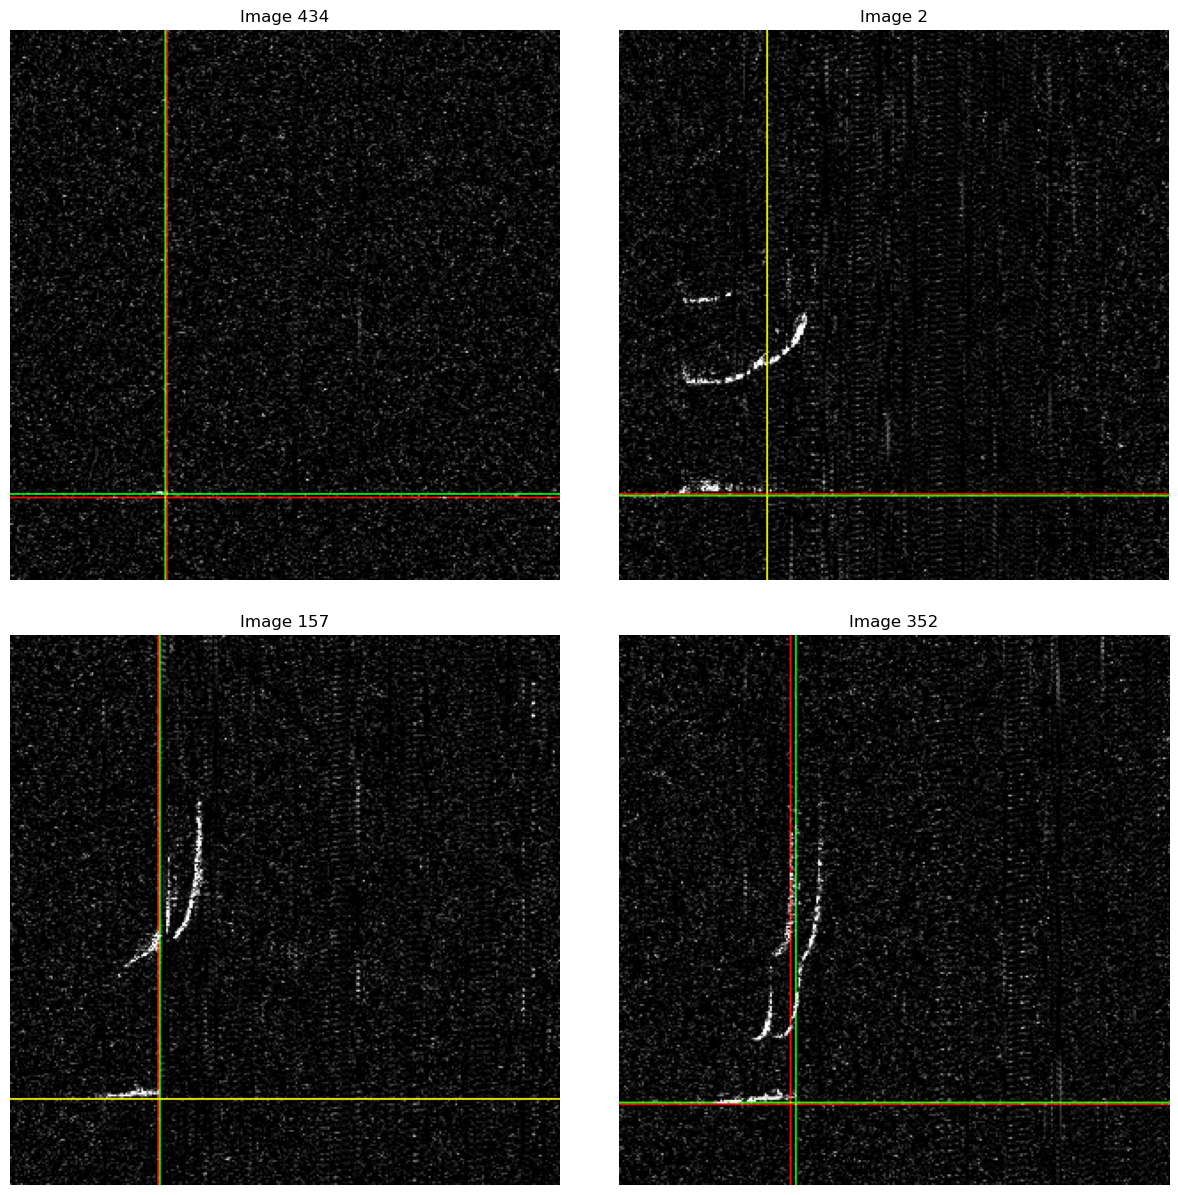

In [30]:
# Select 9 random images and their labels from the test set
indices = random.sample(range(len(X_test)), 4)
sample_images = X_test[indices]
sample_labels = y_test[indices]
sample_predictions = median_predictions[indices]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    # Original image flipped
    img = np.flipud(sample_images[i].squeeze())  # Remove channel dimension and flip

    # True and predicted values, adjusted for the flip
    true_vertical, true_horizontal = sample_labels[i]  # Swap the order here
    true_horizontal = img.shape[0] - true_horizontal  # Adjust for flipping
    pred_vertical, pred_horizontal = sample_predictions[i]  # Swap the order here
    pred_horizontal = img.shape[0] - pred_horizontal  # Adjust for flipping

    # Draw lines
    img_with_true_lines = draw_colored_lines_on_image(img, true_horizontal, true_vertical, color='g')
    img_with_pred_lines = draw_colored_lines_on_image(img, pred_horizontal, pred_vertical, color='r')

    # Combined image
    combined_img = np.maximum(img_with_true_lines, img_with_pred_lines)

    # Display the image
    ax.imshow(combined_img, cmap='gray')
    ax.set_title(f"Image {indices[i]}")
    ax.axis('off')

plt.show()